In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#   COMPUTING THE INTEGRALS IS COSTLY, SO WE TRAIN A NN TO REPRODUCE THE VALUE OF THE INTEGRAL ON SOME POINTS
#   EXPECTING TABLE FORMATTED AS: Temperature mass/Temperature width/Temperature \chi
#   REFER TO FORMULAE 15 OF 2311.15984
#   THIS SCRIPT IS FOR A NN THAT SHOULD ESTIMATE THE INTEGRAL FOR A GIVEN T m/T AND \gamma/T

table_path = "./table_chi_large.dat"
table = np.loadtxt(table_path,unpack=True)

table_T = table[0] #GeV
table_moT = table[1]
table_woT = table[2]
table_chioT2 = table[3]


max_chib = np.max(table_chioT2)
table_chiB = table_chioT2/max_chib #Preprocessing: normalizing the integrals in the table. The max value will be used in the DQPMNN so save it!

table_data = np.stack((table_T,table_moT,table_woT),axis=1)

training_set, validation_set, training_label, validation_label = train_test_split(table_data,table_chiB,test_size=0.3)
print(max_chib)

0.133045


In [ ]:
#       NEURAL NET: SURROGATE MODEL FOR THE INTEGRAL CALCULATIONS
#       WE TRAIN THE NN TO REPRODUCE THE INTEGRALS IN THE TABLES
#
#       INPUT: T m/T \gamma/T             OUTPUT: \chi


surrogate = tf.keras.Sequential()
surrogate.add( tf.keras.layers.Dense(128,activation='sigmoid') )
surrogate.add( tf.keras.layers.Dense(128,activation='sigmoid') )
surrogate.add( tf.keras.layers.Dense(64,activation='sigmoid') )
surrogate.add( tf.keras.layers.Dense(1,activation='sigmoid') ) #To access the output: \chi = surrogate[:,0]

surrogate.build ( input_shape =(None,3) )

@tf.function
def surrogate_loss(data,labels):
        metric = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size') #We use the min of the squared error as metric
        return metric(surrogate(data),labels)

optimizer = tf.optimizers.Adam(0.005)

@tf.function
def surrogate_train(data, labels):
  #training function
  with tf.GradientTape() as gt:
    gt.watch ( surrogate.variables )
    loss_ = surrogate_loss(data,labels)
    grads = gt.gradient (loss_, surrogate.variables)
    optimizer.apply_gradients (zip(grads, surrogate.variables))
    return loss_

surrogate.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25,345
Trainable params: 25,345
Non-trainable params: 0
_________________________________________________________________


 100% [====================================================================================================>] 
Total loss= 7.984456465873676e-08  loss validation= 9.142861147984302e-08


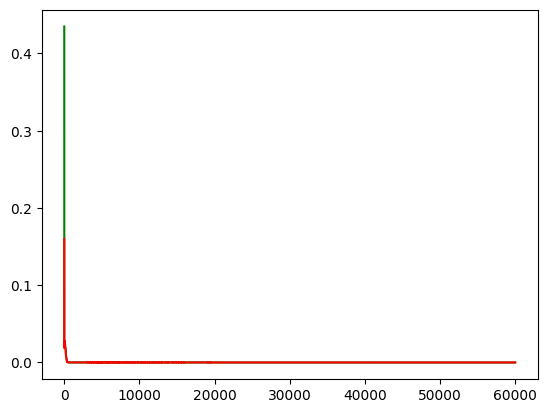

In [ ]:
#In these lists I store the value of the loss function.
loss_train = []
loss_validation=[]

#Training stage
epoch = 60000
for i in range(epoch):
  #training and appending the losses in the lists
  loss_train.append ( surrogate_train(training_set,training_label) )
  loss_validation.append( surrogate_loss(validation_set,validation_label) )
  #the following snippet prints a progress bar for the training
  row = "["+"="*int(100/epoch *(i+1)) + ">"+"."*(int(100-100/epoch *(i+1)))+"]"
  sys.stdout.write("\r %d%% %s " %( int(100/epoch *(i + 1)),row))
  sys.stdout.flush()

sys.stdout.write("\n")

#plot the training and validation losses
plt.subplots()
plt.plot ( loss_train, 'g' )
plt.plot(loss_validation,'r')

print("Total loss=",loss_train[-1].numpy(),' loss validation=',loss_validation[-1].numpy())
if loss_train[-1]<loss_validation[-1]:
  print("WARNING: learning by heart")

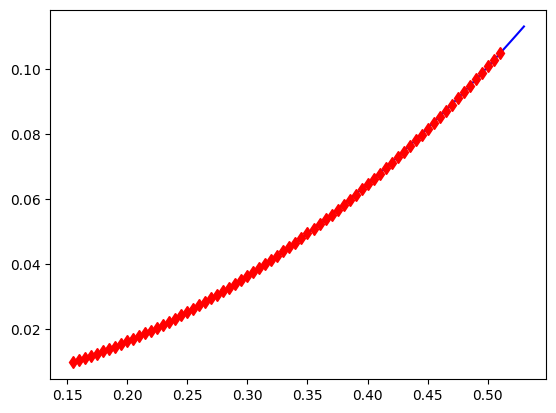

In [ ]:
# TEST PLOTS
x = np.linspace(0.158, 0.53, 100)
y=[]
for xi in x:
    y.append(np.array( surrogate(np.reshape([xi,6, 3.38],(1,3))))[0,0])
y=np.array(y)


T_selection = (table_T==0.275)
width_selection = (table_woT==3.38)
mass_selection = (table_moT == 6.)

selection = mass_selection & width_selection

plt.plot(x, y,'b')
plt.plot(table_T[selection],table_chiB[selection],"rd")
# show plot
plt.show()

In [ ]:
# surrogate.save('../surrogate_chi_math.h5')